# Model Comparison Example
One of `LITMUS`'s core features is that it can not only constrain the lag, but use Bayesian model comparison to determine how good of a fit that actually is, i.e. whether the recovere lag is significant. In this example we show how to get model evidences and see if / when we actually trust our recovered lags.

Per usual, start with some imports:

In [1]:
import matplotlib.pyplot as plt

from litmus import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Then define the different models. `model_alt` is our alternative hypothesis, i.e. "_The signal encodes a lag and we have seen it_". The other two models are null hypothesese, with `model_null` being "_there is information in the signal but we did not measure a lag_", and `model_whitenoise` is "_the response signal is so choppy we can't measure anything at all_". For cleanness of the notebook I'm setting al of these to `verbose=False` to suppress their progress messages:

In [2]:
model_alt = litmus.models.GP_simple(verbose=False)
model_null = litmus.models.GP_simple_null(verbose=False)
model_whitenoise = litmus.models.whitenoise_null(verbose=False)

MODELS = [model_alt, model_null, model_whitenoise]

This is the code used to generate the evidence examples in the [`LITMUS` paper](https://www.something.com), and here I've got a switch, `vague`, to flick between two sets of mock signals. If `vague=False` we generate some nice crisp signals with good cadence, easy to observe timescales of variation and nice measurement uncertainties. If `vague=True` the uncertainties get larger and the timescale is shortened to make it harder to track the variability. In either case, the procedure here is to generate three mocks, each corresponding to a "true" case of one of the model's we're testing.
1. `mock` has a true lag of $540 \mathrm{d}$.
2. `mock1_null` has no true lag, but both driving and response lightcurves have good signal-to-noise. This corresponds to a lag beyond our prior, or a response that's become physically decoupled.
3. `mock1_whitenoise` encodes no lag and has a response that is degraded to the point of being white noise.

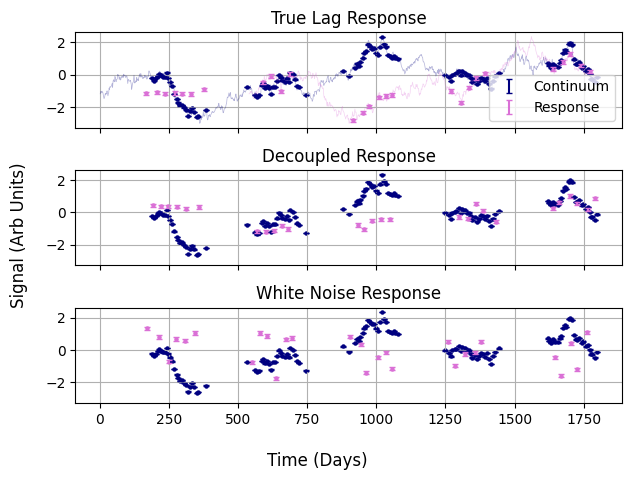

In [3]:
vague = False

if not vague:
    mock1 = litmus.mocks.mock(1, lag=540, tau=200, E=[0.01, 0.1])
    mock2 = mock1.copy(seed=5)
    mock3 = litmus.mocks.mock(8, lag=180, tau=0.001, E=[0.01, 0.1])
else:
    mock1 = litmus.mocks.mock(3, lag=540, tau=50, E=[0.2, 0.5])
    mock2 = mock1.copy(seed=5)
    mock3 = litmus.mocks.mock(8, lag=180, tau=0.001, E=[0.2, 0.5])

mock1_null, mock1_whitenoise = mock1.copy(), mock1.copy()
mock1_null.swap_response(mock2)
mock1_whitenoise.swap_response(mock3)

MOCKS = [mock1, mock1_null, mock1_whitenoise]
mock1.name = "Positive"
mock1_null.name = "Negative"
mock1_whitenoise.name = "Noise"

#----------------------------
fig, axes = plt.subplots(len(MOCKS), 1, sharex=True, sharey=True)
for mock, ax in zip(MOCKS, axes):
    mock.plot(axis=ax, show=False,
              true_args={'c': ['navy', 'orchid'], 'label': [None, None]},
              series_args={'c': ['navy', 'orchid'], 'label': ["Continuum", "Response"]}
              )
    ax.grid()
fig.supxlabel("Time (Days)"), fig.supylabel("Signal (Arb Units)")
axes[0].set_title("True Lag Response"), axes[1].set_title("Decoupled Response"), axes[2].set_title(
    "White Noise Response")
axes[0].legend()
fig.tight_layout()
plt.show()

Now nothing to it but to do it. We're going to use the `SVI_scan` to fit all of the models and calculate their evidences in a 3x3 grid. Notice I've lowered `grid_bunching` to `0.25` to make sure the test lags are spread out enough to get a good evidence integral:

In [4]:
Z = []
FITTERS = []
for mock in MOCKS:
    for model in MODELS:
        fitter = litmus.fitting_methods.SVI_scan(model, Nlags=128, precondition="diag", ELBO_Nsteps=512,
                                                 grid_bunching=0.25, verbose=False)
        fitter.name = mock.name + " " + model.name
        fitter.fit(mock.lc_1, mock.lc_2)

        FITTERS.append(fitter)

        Z.append(fitter.get_evidence())


Before we actually use these fits to do the model comparison, let's see _why_ this is necessary. In addition to getting evidences, `LITMUS` fitters can also generate MCMC-like chains for parameter constraint. Grabbing the fitters that fit for the alternative model, i.e. the ones that fit for lags, we can plot their constraints on the lag.

When we do, we can see that all three mock cases produced what _looked_ like a clear and precise lag, even though only 1/3 of them actually had a real underlying lag to recover. The second and third recoveries are **false positives**:

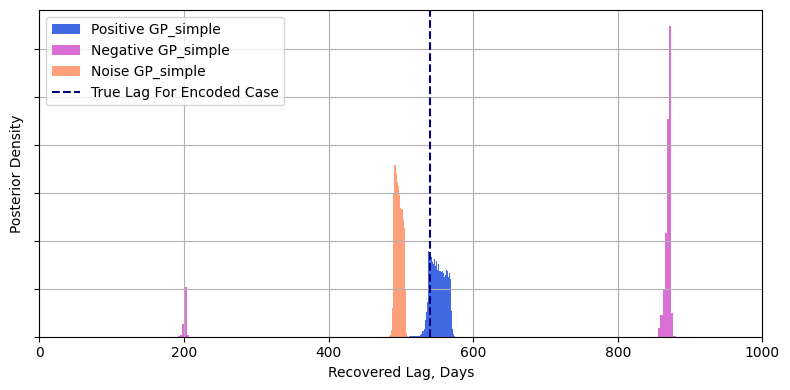

In [15]:
fig = plt.figure(figsize=(8,4))
for i, c in enumerate(['#4169E1','#DA70D6','#FFA07A']):
    samples = FITTERS[3 * i].get_samples(50_000)
    plt.hist(samples['lag'], label = FITTERS[3 * i].name, alpha=1., color = c, bins=256, density=True)
plt.xlim(*model_alt.prior_ranges['lag'])
plt.axvline(mock1_whitenoise.lag, ls='--', color='navy', label = "True Lag For Encoded Case")
plt.gca().set_yticklabels([])
plt.ylabel("Posterior Density")
plt.xlabel("Recovered Lag, Days")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

So how do we identify this failure state? Evidence ratios! We need to know not only what lag was recovered, but whether the model at large does a better job of explaining our data than a null hypothesis. Once you've run a fitter, getting model evidences is as simple as calling `fitter.get_evidence()`.

Evidences in `LITMUS` are returned in linear form, i.e. not logarithmically, so we need to convert back. Traditionally log-evidences are written in log base 10, and we'll work with that here. Bayes ratios only make sense when comparing models as applied to the same data set, so here we'll plot the _relative_ evidence (i.e. _difference_ in evidence compared to the simplest model) for the 3 different models within each mock.  

Plotting these we immediately see that the model with the highest evidence is the one correct one. For the signal with a lag encoded, the alternative model wins out by about $1.7 \mathrm{dex}$, or a factor of about 50, while the decoupled signal strongly favours the decoupled model, and the white noise response signal has both GP response models disfavoured by an enormous margin.

Through evidence-based model comparison we've seperated out the one signal that _actually_ has an encoded lag from the two other false positives.

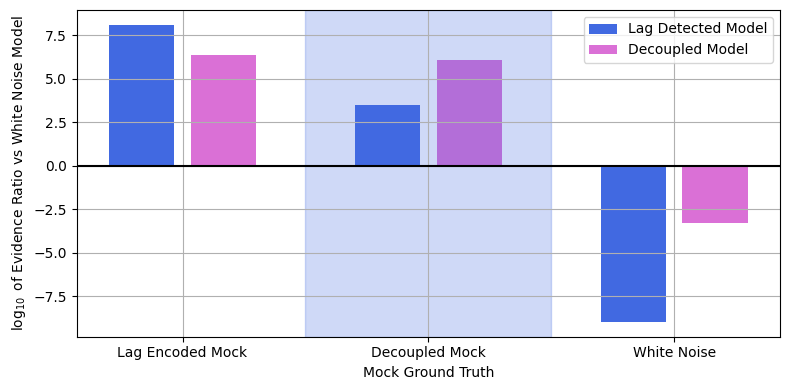

In [19]:
LZ = np.log10(np.array(Z)[:, 0]).reshape(len(MOCKS), len(MODELS))
LZ = np.round(LZ, 2)

plt.figure(figsize=(8,4))


for i, row in enumerate(LZ - np.tile(LZ[:, 2], [len(MODELS), 1]).T):
    plt.bar((np.arange(3) + 3 * i)[0], row[0], color='royalblue', label="Lag Detected Model" if i == 0 else None)
    plt.bar((np.arange(3) + 3 * i)[1], row[1], color='orchid', label="Decoupled Model" if i == 0 else None)

plt.axvspan(2, 5, alpha=0.25, color='royalblue')
plt.axhline(y=0, color='black')

plt.xlabel("Mock Ground Truth")
plt.ylabel("$\log_{10}$ of Evidence Ratio vs White Noise Model")

plt.grid()
plt.gca().set_xticks([0.5, 3.5, 6.5])
plt.gca().set_xticklabels(["Lag Encoded Mock", "Decoupled Mock", "White Noise"])
plt.legend()
plt.tight_layout()
plt.show()
